In [1]:
%pip install numpy pandas matplotlib seaborn pillow

import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

plt.style.use("default")

# 👇 IMPORTANT: if this notebook is inside "notebooks/" folder
# BASE_DIR should point to the project root (one level up)
BASE_DIR = Path("..")   # <-- FIXED

CLASSIFICATION_DIR = BASE_DIR / "data" / "classification_dataset"
DETECTION_DIR = BASE_DIR / "data" / "object_detection_Dataset"

print("Current notebook dir:", Path(".").resolve())
print("Project base dir    :", BASE_DIR.resolve())
print("Classification path :", CLASSIFICATION_DIR.resolve())
print("Detection path      :", DETECTION_DIR.resolve())



Note: you may need to restart the kernel to use updated packages.
Current notebook dir: F:\Aerial_Object_Classification_Detection\notebooks
Project base dir    : F:\Aerial_Object_Classification_Detection
Classification path : F:\Aerial_Object_Classification_Detection\data\classification_dataset
Detection path      : F:\Aerial_Object_Classification_Detection\data\object_detection_Dataset


In [2]:
def count_images_in_folder(class_dir):
    """
    Count number of image files in a given folder.
    """
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    return sum(1 for f in class_dir.iterdir() if f.suffix.lower() in exts)


def get_class_counts_classification(split_dir):
    """
    For a given split (train/valid/test), return dict {class_name: count}.
    """
    class_counts = {}
    if not split_dir.exists():
        print(f"[WARN] Split folder does not exist: {split_dir}")
        return class_counts

    for class_folder in sorted(split_dir.iterdir()):
        if class_folder.is_dir():
            class_name = class_folder.name
            count = count_images_in_folder(class_folder)
            class_counts[class_name] = count
    return class_counts


In [3]:
splits = ["train", "valid", "test"]
records = []

for split in splits:
    split_dir = CLASSIFICATION_DIR / split
    class_counts = get_class_counts_classification(split_dir)
    
    for class_name, count in class_counts.items():
        records.append({
            "split": split,
            "class": class_name,
            "count": count
        })

df_class_counts = pd.DataFrame(records)
df_class_counts


,split,class,count
0,train,bird,1414
1,train,drone,1248
2,valid,bird,217
3,valid,drone,225
4,test,bird,121
5,test,drone,94


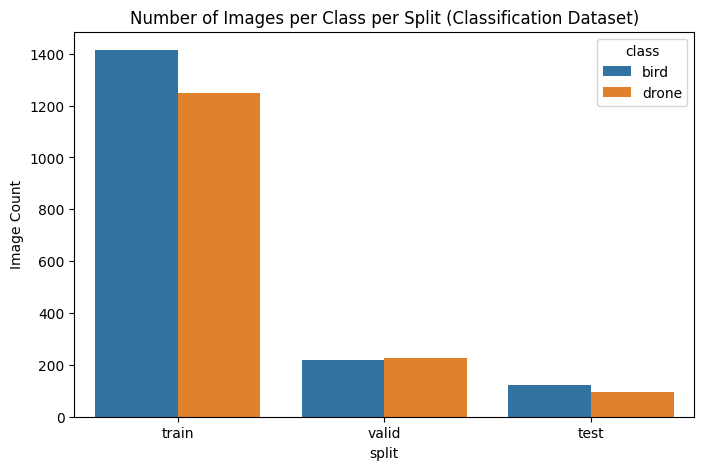

In [4]:
if not df_class_counts.empty:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_class_counts, x="split", y="count", hue="class")
    plt.title("Number of Images per Class per Split (Classification Dataset)")
    plt.ylabel("Image Count")
    plt.show()
else:
    print("No class counts found. Check dataset paths.")


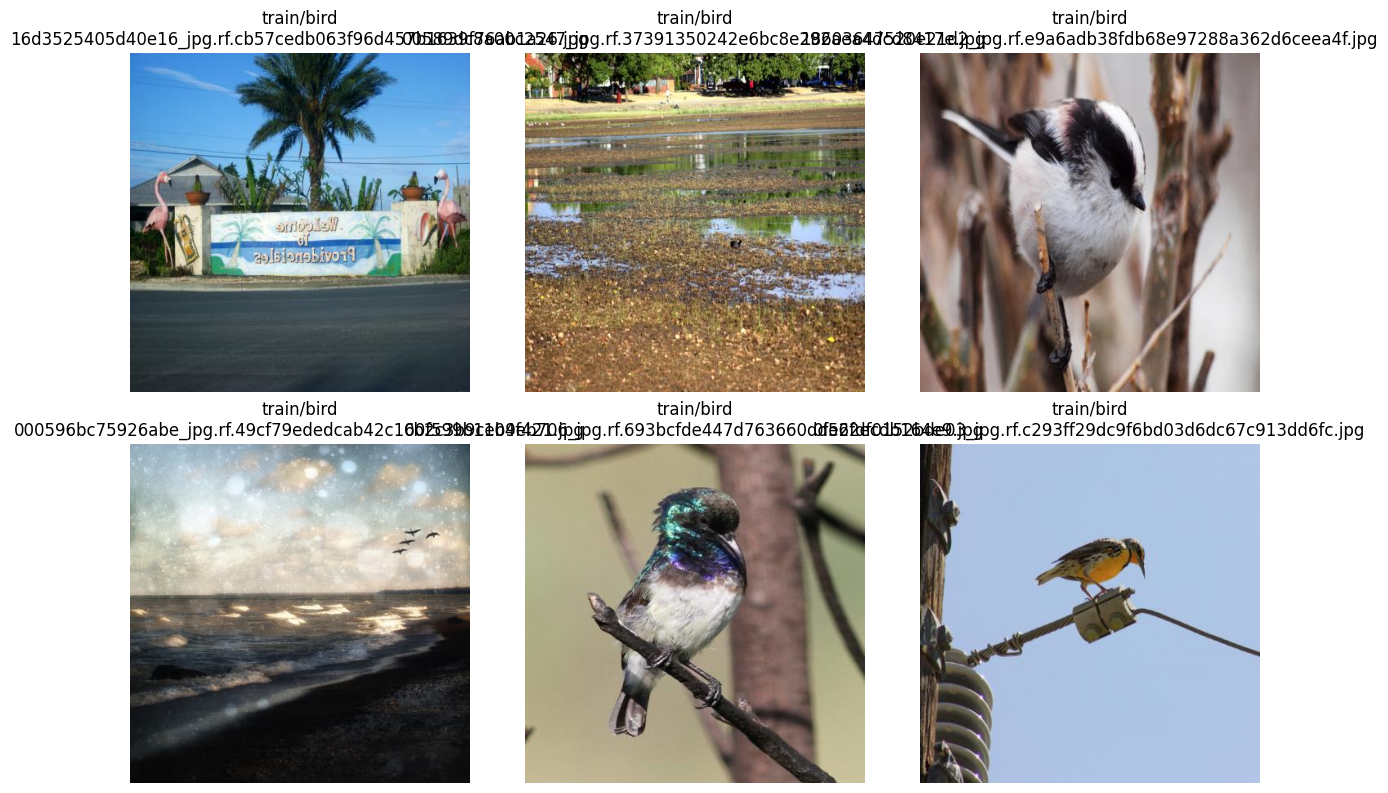

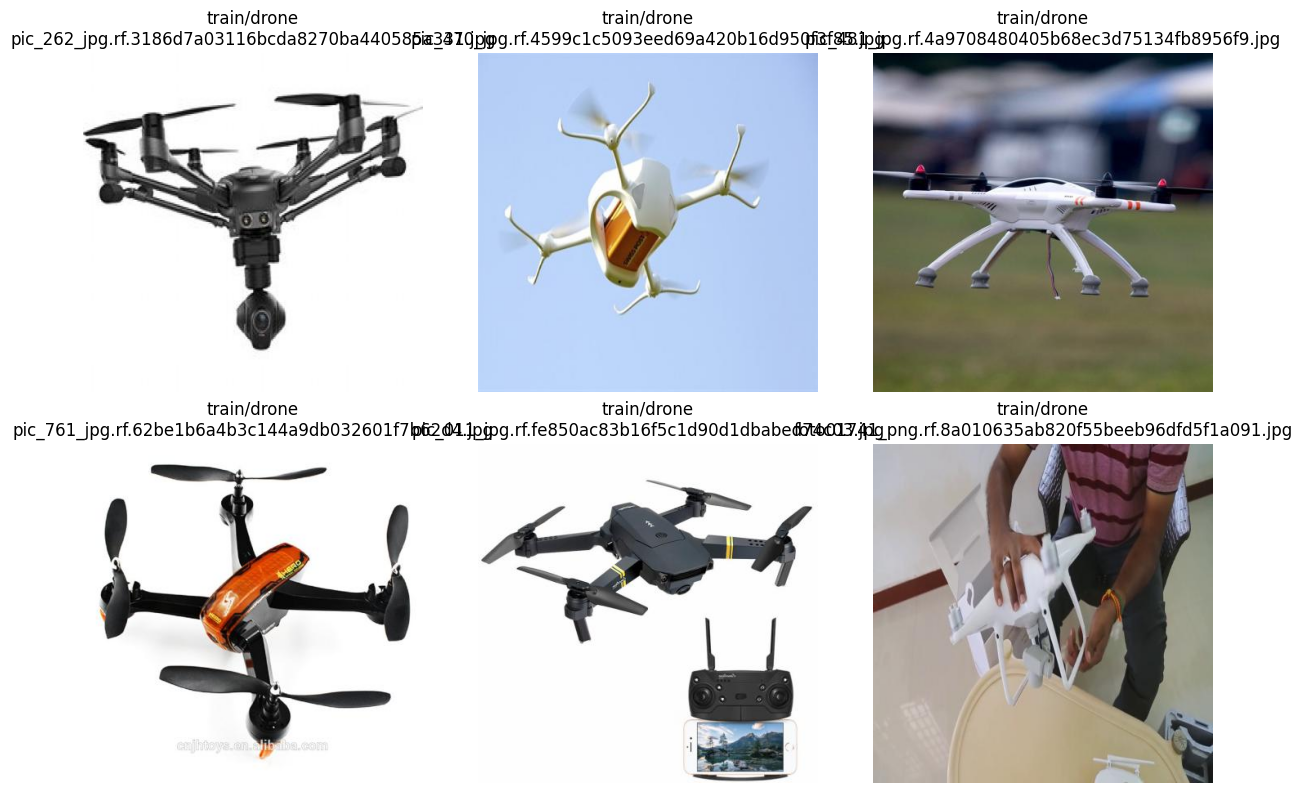

In [5]:
def show_sample_images(split="train", class_name="bird", num_samples=6):
    split_dir = CLASSIFICATION_DIR / split / class_name
    if not split_dir.exists():
        print(f"[ERROR] Folder does not exist: {split_dir}")
        return
    
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    image_files = [f for f in split_dir.iterdir() if f.suffix.lower() in exts]
    
    if len(image_files) == 0:
        print(f"No images found in {split_dir}")
        return
    
    num_samples = min(num_samples, len(image_files))
    sample_files = random.sample(image_files, num_samples)

    cols = 3
    rows = int(np.ceil(num_samples / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, img_path in enumerate(sample_files, 1):
        img = Image.open(img_path).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(f"{split}/{class_name}\n{img_path.name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show sample bird images
show_sample_images(split="train", class_name="bird", num_samples=6)

# Show sample drone images
show_sample_images(split="train", class_name="drone", num_samples=6)


In [6]:
def count_images_and_labels_yolo(split="train"):
    split_images = DETECTION_DIR / split / "images"
    split_labels = DETECTION_DIR / split / "labels"
    
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    image_files = [f for f in split_images.iterdir() if f.suffix.lower() in exts] if split_images.exists() else []
    label_files = [f for f in split_labels.iterdir() if f.suffix.lower() == ".txt"] if split_labels.exists() else []
    
    return len(image_files), len(label_files)

yolo_records = []

for split in ["train", "valid", "test"]:
    img_count, lbl_count = count_images_and_labels_yolo(split)
    yolo_records.append({
        "split": split,
        "image_count": img_count,
        "label_count": lbl_count
    })

df_yolo_counts = pd.DataFrame(yolo_records)
df_yolo_counts


,split,image_count,label_count
0,train,2728,2728
1,valid,448,448
2,test,224,224


In [7]:
def read_random_label_example(split="train"):
    labels_dir = DETECTION_DIR / split / "labels"
    if not labels_dir.exists():
        print(f"[ERROR] Labels directory does not exist: {labels_dir}")
        return
    
    label_files = [f for f in labels_dir.iterdir() if f.suffix.lower() == ".txt"]
    if len(label_files) == 0:
        print(f"No label files found in {labels_dir}")
        return
    
    sample_label = random.choice(label_files)
    print("Sample label file:", sample_label)
    
    with open(sample_label, "r") as f:
        lines = f.read().strip().splitlines()
    
    print("File content:")
    for line in lines:
        print(line)

read_random_label_example(split="train")


Sample label file: ..\data\object_detection_Dataset\train\labels\pic_413_jpg.rf.8233e8a2a3377c5848b0abb578853618.txt
File content:
1 0.4735576923076923 0.3894230769230769 0.8822115384615384 0.4387019230769231


Note: you may need to restart the kernel to use updated packages.
Image: ..\data\object_detection_Dataset\train\images\1b2a5f13888cbbde_jpg.rf.22cb7c3b720bf1187b01502a24513327.jpg
Label: ..\data\object_detection_Dataset\train\labels\1b2a5f13888cbbde_jpg.rf.22cb7c3b720bf1187b01502a24513327.txt


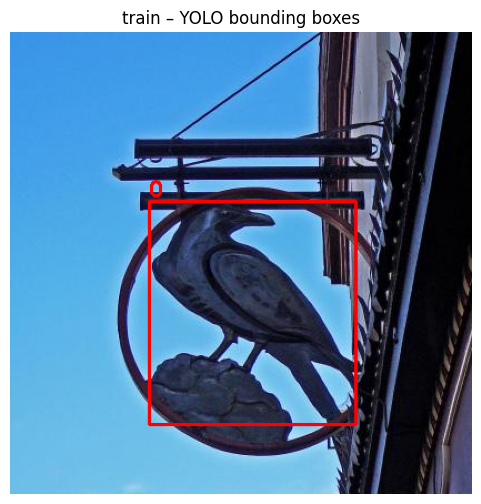

In [8]:
%pip install opencv-python

import cv2

def plot_yolo_boxes(split="train"):
    images_dir = DETECTION_DIR / split / "images"
    labels_dir = DETECTION_DIR / split / "labels"
    
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    image_files = [f for f in images_dir.iterdir() if f.suffix.lower() in exts] if images_dir.exists() else []
    
    if len(image_files) == 0:
        print(f"No images found in {images_dir}")
        return
    
    # pick random image
    img_path = random.choice(image_files)
    label_path = labels_dir / (img_path.stem + ".txt")
    
    print("Image:", img_path)
    print("Label:", label_path)
    
    img = cv2.imread(str(img_path))
    if img is None:
        print("[ERROR] Could not read image.")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    
    if not label_path.exists():
        print("No label file for this image.")
    else:
        with open(label_path, "r") as f:
            for line in f.read().strip().splitlines():
                if not line:
                    continue
                class_id, x_c, y_c, bw, bh = map(float, line.split())
                # YOLO format is normalized (0-1), convert to pixel coords
                x_c *= w
                y_c *= h
                bw *= w
                bh *= h

                x1 = int(x_c - bw / 2)
                y1 = int(y_c - bh / 2)
                x2 = int(x_c + bw / 2)
                y2 = int(y_c + bh / 2)

                # draw rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, str(int(class_id)), (x1, max(0, y1 - 5)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{split} – YOLO bounding boxes")
    plt.show()

plot_yolo_boxes(split="train")
